# Monte Carlo model of $A_n$ + $B_m$ polycondensation

## Introduction

This is a simple implementation of a Monte Carlo algorithm to compute the evolution of the chain-length distribution in a classical $A_n$ + $B_m$ polycondensation reaction. The solution is obtained as a function of the conversion of endgroups of type $A$, which is assumed to be the limiting species, rather than as a function of time.

Typically, stochastic simulations of chemical reactions are performed using [Gillespie's algorithm](https://en.wikipedia.org/wiki/Gillespie_algorithm). However, since this case involves only one reaction and we are not focused on the temporal evolution, a simpler approach is sufficient. In simple terms, the algorithm proceeds as follows:

1. Build a "table" of species and populate it with the initial number of $A_n$ and $B_m$ molecules.
1. Randomly select a molecule with an endgroup of type $A$.
1. Randomly select a different molecule with an endgroup of type $B$. By ensuring that two distinct molecules are chosen, cyclization is prevented.
1. Create a new product molecule by joining/condensing the two selected molecules.
1. Update the table by removing the reacted molecules and adding the newly formed molecule.
1. Count the remaining functional groups to calculate the degree of conversion for the ensemble.
1. If the conversion is below the target value, repeat from step 2. Otherwise, stop.


## Numerical solution

In [1]:
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np

### Input parameters

In [2]:
# Endgroup stoichiometry
# ratio <= 1, since A is assumed the limiting reactant
ratio_endgroups_A_B = 1.

# Functionality of monomers
fA = 2
fB = 2

# Method settings
number_molecules_start = 5000
conversion_A_stop = 0.99         # The simulation will run until this limit
constant_number = True           # True: constant number, False: constant mass

### Gelation check

In [3]:
# Average functionality and gel condition according to Carothers
favg = 2*fA*fB*ratio_endgroups_A_B/(fA + fB*ratio_endgroups_A_B)
if favg > 2:
    print(f"Warning: gelation at x_gel: {2/favg:.3f}")

### Auxiliary functions

In [4]:
# These functions accept a state array or an array of state arrays.

def get_number_molecules(state: np.ndarray):
    "Return number of molecules."
    return np.sum(state['active'], -1)


def get_number_units(state: np.ndarray, X: Literal['A', 'B']):
    "Return number of units of type `X`."
    return np.sum(state[f"n{X}"], -1)


def get_moment(state: np.ndarray, k: int):
    "Return k-th _positive_ moment."
    return np.sum((state['nA'] + state['nB'])**k, -1)


def get_chain_lengths(state: np.ndarray):
    "Return array of chain lengths."
    return state['nA'] + state['nB']


def get_number_groups(state: np.ndarray, X: Literal['A', 'B']):
    "Return number of unreacted `X` groups."
    return np.sum(state[f"f{X}"], -1)


def get_conversion(state: np.ndarray):
    "Return conversion of `A` groups."
    NA0 = get_number_units(state, 'A')*fA
    return 1.0 - get_number_groups(state, 'A') / NA0


def cumsum_norm(a: np.ndarray):
    "Return normalized cumulative sum of array elements."
    return np.cumsum(a) / np.maximum(1, np.sum(a))

### Stochastic algorithm

In [5]:
# Properties to be tracked for each molecule
spec_state_dtype = [
    ('active', '?'),
    ('nA', 'i2'),  # number of embeded A molecules
    ('nB', 'i2'),  # number of embeded B molecules
    ('fA', 'i2'),  # number of endgroups of type A
    ('fB', 'i2'),  # number of endgroups of type B
]

# Initialize array to store current state of all molecules
state = np.empty(number_molecules_start, dtype=np.dtype(spec_state_dtype))

# Initial stoichiometry
molefrac_A = ratio_endgroups_A_B/(fA/fB + ratio_endgroups_A_B)
number_molecules_start_A = round(number_molecules_start*molefrac_A)

# Populate state array with reactant molecules
state['active'] = True
# Add molecules A(fA)
state['nA'][:number_molecules_start_A] = 1
state['nB'][:number_molecules_start_A] = 0
state['fA'][:number_molecules_start_A] = fA
state['fB'][:number_molecules_start_A] = 0
# Add molecules B(fB)
state['nA'][number_molecules_start_A:] = 0
state['nB'][number_molecules_start_A:] = 1
state['fA'][number_molecules_start_A:] = 0
state['fB'][number_molecules_start_A:] = fB

# Schuffle state array - not required but good practice
np.random.shuffle(state)

# MC algorithm
stored_states = []
number_stored_states = 100
while True:

    # Randomly select a molecule with endgroup A
    cumsum_fA = cumsum_norm(state['fA'])
    index_molecule1 = np.nonzero(cumsum_fA > np.random.rand())[0][0]
    molecule1 = state[index_molecule1]

    # Randomly select a _distinct_ molecule with endgroup B
    while True:
        cumsum_fB = cumsum_norm(state['fB'])
        try:
            index_molecule2 = np.nonzero(cumsum_fB > np.random.rand())[0][0]
            if index_molecule2 != index_molecule1:
                break
        except IndexError:
            index_molecule2 = None
            break
    if index_molecule2 is None:
        break
    else:
        molecule2 = state[index_molecule2]

    # Create new molecule, by updating the state of molecule 1
    # Updading a view updates the array!
    new_molecule = molecule1
    new_molecule['nA'] += molecule2['nA']
    new_molecule['nB'] += molecule2['nB']
    new_molecule['fA'] += molecule2['fA'] - 1
    new_molecule['fB'] += molecule2['fB'] - 1

    if constant_number:
        # Add copy of a random molecule to replace molecule 2
        while True:
            index_copy = np.random.randint(number_molecules_start)
            if index_copy != index_molecule2:
                state[index_molecule2] = state[index_copy].copy()
                break
    else:
        # 'Erase' molecule 2
        state[index_molecule2] = 0

    # Compute conversion
    conversion_A = get_conversion(state)

    # Store state snapshot
    # If memory were a probem, we could calculate the desired properties
    # inside the loop, bypassing the need to store the full state
    if (conversion_A * number_stored_states / conversion_A_stop - 1 > len(stored_states)):
        stored_states.append(state.copy())

    # Exit conditions
    condition_1 = conversion_A > conversion_A_stop
    condition_2 = conversion_A > 2/favg*(1 - 2/number_stored_states)
    condition_3 = get_number_molecules(state) < 2

    if condition_1 or condition_2 or condition_3:
        break

### Plot MC Results

#### Moments, etc.

Text(0.5, 0, 'Conversion of endgroups A')

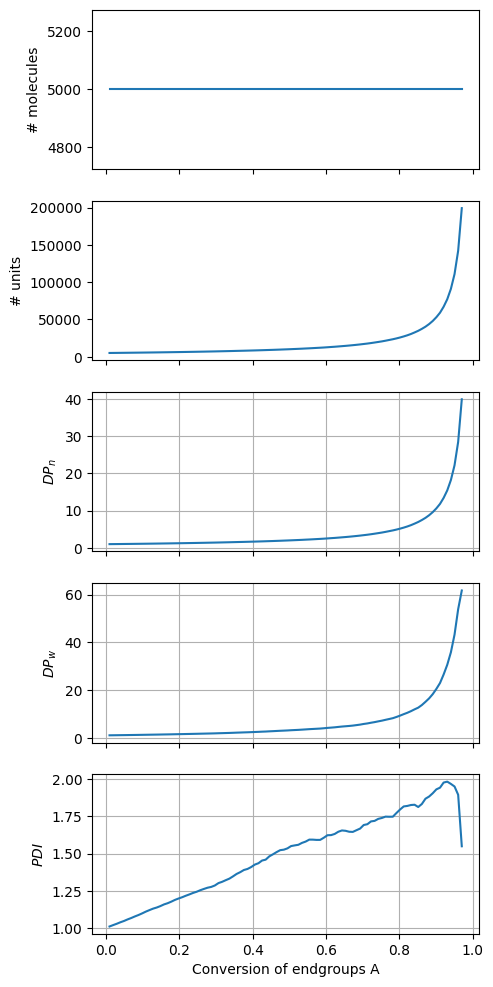

In [6]:
# Compute quantities of interest
stored_states = np.asarray(stored_states)
number_molecules = get_number_molecules(stored_states)
conversion_A = get_conversion(stored_states)
moment_1 = get_moment(stored_states, 1)
moment_2 = get_moment(stored_states, 2)
DPn = moment_1/number_molecules
DPw = moment_2/moment_1
PDI = DPw/DPn

# Plots
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(5, 12))

ax[0].set_ylabel("# molecules")
ax[0].plot(conversion_A, number_molecules)

ax[1].set_ylabel("# units")
ax[1].plot(conversion_A, moment_1)

ax[2].set_ylabel(r"$DP_n$")
ax[2].plot(conversion_A, DPn)
ax[2].grid(True)

ax[3].set_ylabel(r"$DP_w$")
ax[3].plot(conversion_A, DPw)
ax[3].grid(True)

ax[4].set_ylabel(r"$PDI$")
ax[4].plot(conversion_A, PDI)
ax[4].grid(True)

ax[-1].set_xlabel("Conversion of endgroups A")

#### Full Distribution

In [7]:
chain_lengths = get_chain_lengths(stored_states)

CLD = []
for i in range(chain_lengths.shape[0]):
    bins = np.arange(0.5, np.max(chain_lengths[i, :]) + 0.5)
    cld = np.histogram(chain_lengths[i, :], bins=bins, density=True)
    CLD.append(cld)

Text(0.5, 0, 'Chain length')

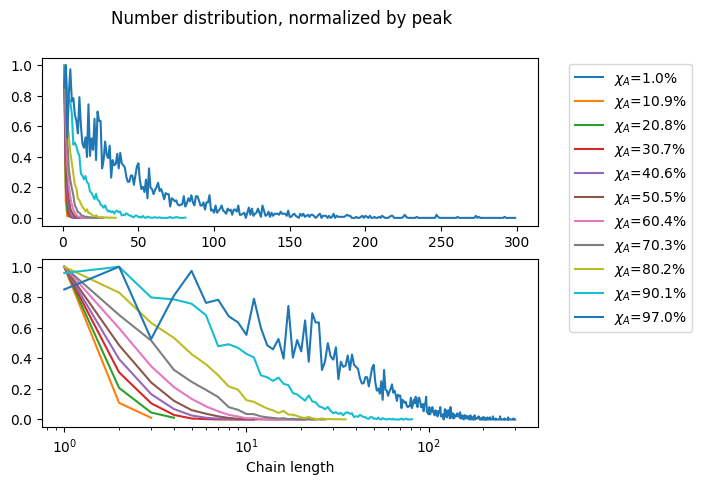

In [8]:
fig2, ax = plt.subplots(2, 1)

fig2.suptitle("Number distribution, normalized by peak")

selected_indexes = [i for i in range(0, len(CLD), round(len(CLD)/10))]
selected_indexes.append(len(CLD)-1)

for i in selected_indexes:
    y, x = CLD[i]
    x = (x[:-1] + x[1:])/2
    y = y/y.max()
    label = r"$\chi_A$=" + f"{100*conversion_A[i]:.1f}%"
    ax[0].plot(x, y, label=label)
    ax[1].semilogx(x, y, label=label)

ax[0].legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
ax[-1].set_xlabel("Chain length")

## Questions

1. Why is the $DP_n$ curve free of stochastic noise?
1. Why is the $DP_w$ curve less smooth than the $DP_n$ curve?
1. What happens to the distribution when `ratio_endgroups_A_B < 1`? Why?
1. What are the relative advantages and disadvantages of the constant mass and constant number methods?
1. Can you devise other approaches to keep the number of molecules (approximately) constant?
